In [298]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [319]:
import sys
sys.path.append('..')
import functools
import math

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [320]:
mixmeans_test = torch.tensor([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = torch.ones((12,1))
mixweights_test = torch.ones(12)/12
def logprob_mixgaussians(x,mixmeans,mixvars,mixweights):
    return bvbq_torch.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans,mixvars,mixweights).reshape(-1,1)
eval_function = functools.partial(logprob_mixgaussians,
                                  mixmeans=mixmeans_test,
                                  mixvars=mixvars_test,
                                  mixweights=mixweights_test)


In [321]:
def logprob_mixgaussians(x,mixmeans,mixvars,mixweights):
    return bvbq_torch.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)

In [324]:
bvbq_obj = bvbq_torch.BVBQMixMVN(eval_function,1)
bvbq_obj.initialize_data(xdata=xdata,ydata=ydata,kind='sqe')
bvbq_obj.optimize_gp_params(tol=1e-1,method='L-BFGS-B')
mean = torch.randn((1,))
var = torch.distributions.HalfNormal(1.0).sample((1,))
bvbq_obj.initialize_components(mean=mean,var=var)

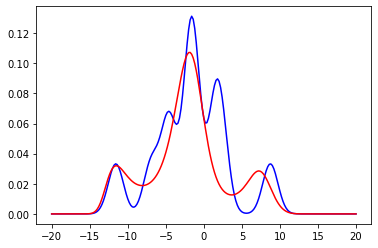

In [325]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = eval_function(xplot).detach().numpy()
yplot2 = bvbq_obj.logprobgp.predict(xplot,return_cov=False).detach().numpy()
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
samples1 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test).detach().numpy()
# plt.hist(samples1.flatten(),density=True,bins=100);

In [347]:
mean = torch.randn((1,))
var = torch.distributions.HalfNormal(1.0).sample((1,))
bvbq_obj.initialize_components(mean=mean,var=var)

In [348]:
metrics = [bvbq_obj.elbo_metric()]
for k in range(20):
    bvbq_obj.update_distribution()
    metrics.append(bvbq_obj.elbo_metric())
#     bvbq_obj.update_evaluations('MMLT')

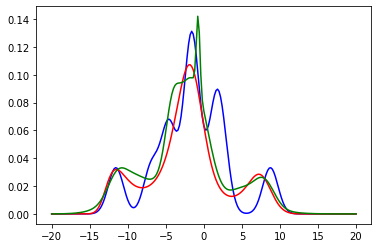

In [343]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = eval_function(xplot).detach().numpy()
yplot2 = bvbq_obj.logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = bvbq_obj.distribution.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')

In [344]:
elbo_mean,elbo_var = list(zip(*metrics))
elbo_mean,elbo_var = torch.hstack(elbo_mean).numpy(),torch.hstack(elbo_var).numpy()

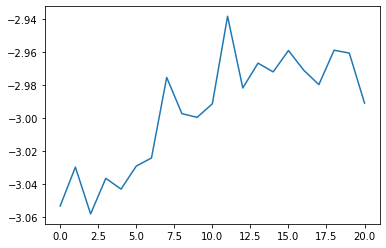

In [345]:
plt.plot(elbo_mean)

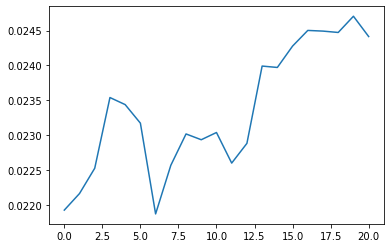

In [346]:
plt.plot(elbo_var)